In [1]:
from bayestme import data

stdata = data.SpatialExpressionDataset.read_spaceranger("../A1_spaceranger_output")

In [2]:
stdata.gene_names

array(['rerg', 'si:ch73-252i11.1', 'syn3', ..., 'CABZ01079745.1',
       'BRAFhuman', 'EGFP'], dtype='<U22')

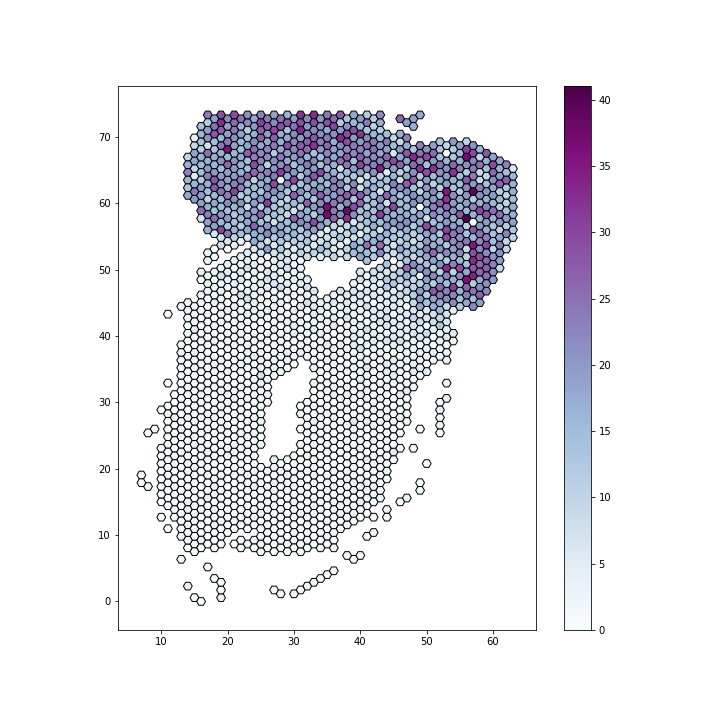

In [5]:
from bayestme import plotting
from IPython.display import Image
from matplotlib import pyplot as plt

plt.rcParams["figure.figsize"] = (10, 10)
plotting.plot_gene_raw_counts(stdata=stdata, gene='BRAFhuman', output_file='BRAFhuman_raw.png')


Image('BRAFhuman_raw.png')

In [9]:
from bayestme import gene_filtering

stddev_filtered = gene_filtering.select_top_genes_by_standard_deviation(
    stdata, n_gene=20)

spot_threshold_filtered = gene_filtering.filter_genes_by_spot_threshold(
    stddev_filtered, spot_threshold=0.95)

stdata_filtered = gene_filtering.filter_ribosome_genes(spot_threshold_filtered)

In [10]:
print('{}/{} genes selected'.format(len(stdata_filtered.gene_names), len(stdata.gene_names)))

13/32268 genes selected


In [ ]:
from bayestme import bleeding_correction

cleaned_dataset, bleed_correction_result = bleeding_correction.clean_bleed(
    dataset=stdata_filtered,
    n_top=20,
    local_weight=None,
    max_steps=3
)

Fitting basis functions to first 13 genes

Step 1/3


Plot saved as ./ckmb_bleeding_plot.png
Plot saved as ./mylpfa_bleeding_plot.png
Plot saved as ./ckma_bleeding_plot.png
Plot saved as ./pvalb3_bleeding_plot.png
Plot saved as ./myhc4_bleeding_plot.png


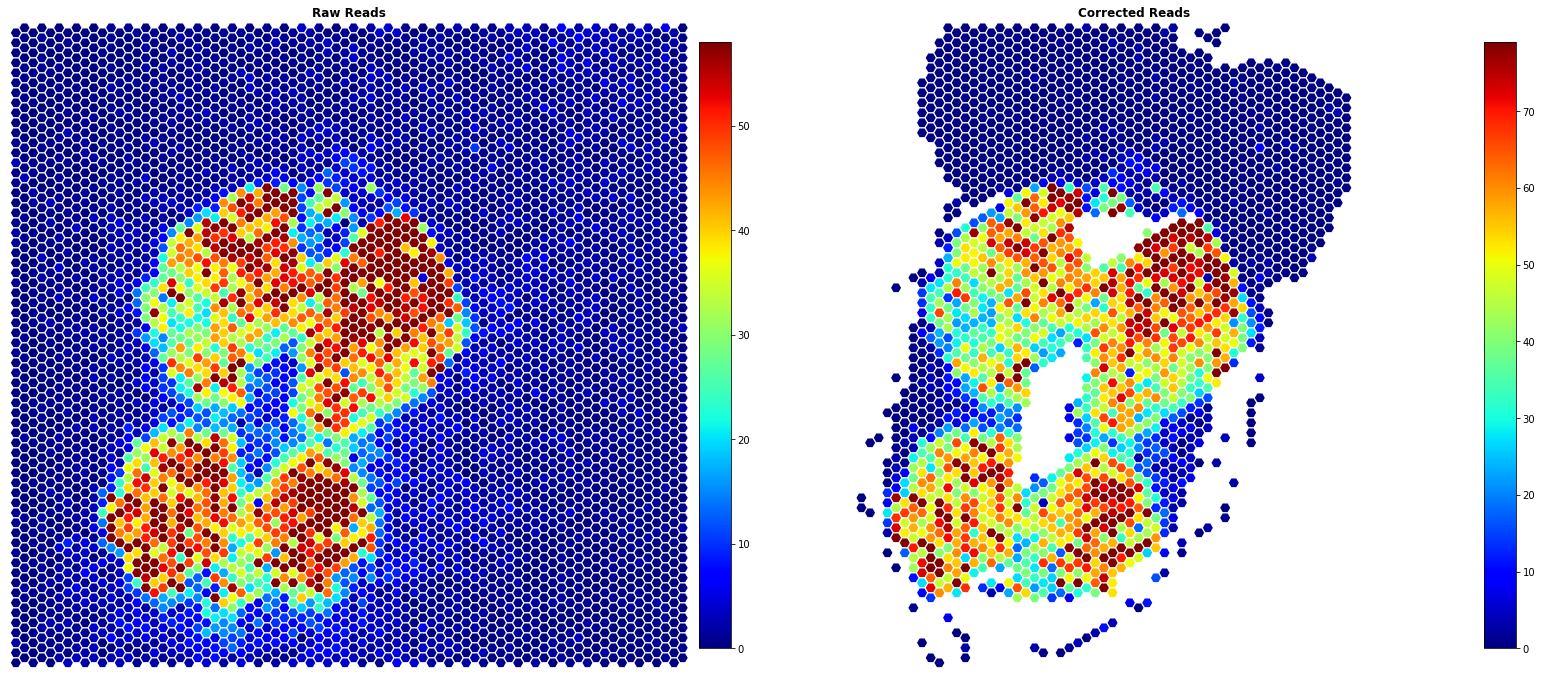

In [13]:
plt.rcParams["figure.figsize"] = (5, 5)
bleeding_correction.create_top_n_gene_bleeding_plots(
        dataset=stdata_filtered,
        corrected_dataset=cleaned_dataset,
        bleed_result=bleed_correction_result,
        output_dir='.',
        output_format='png',
        n_genes=5)



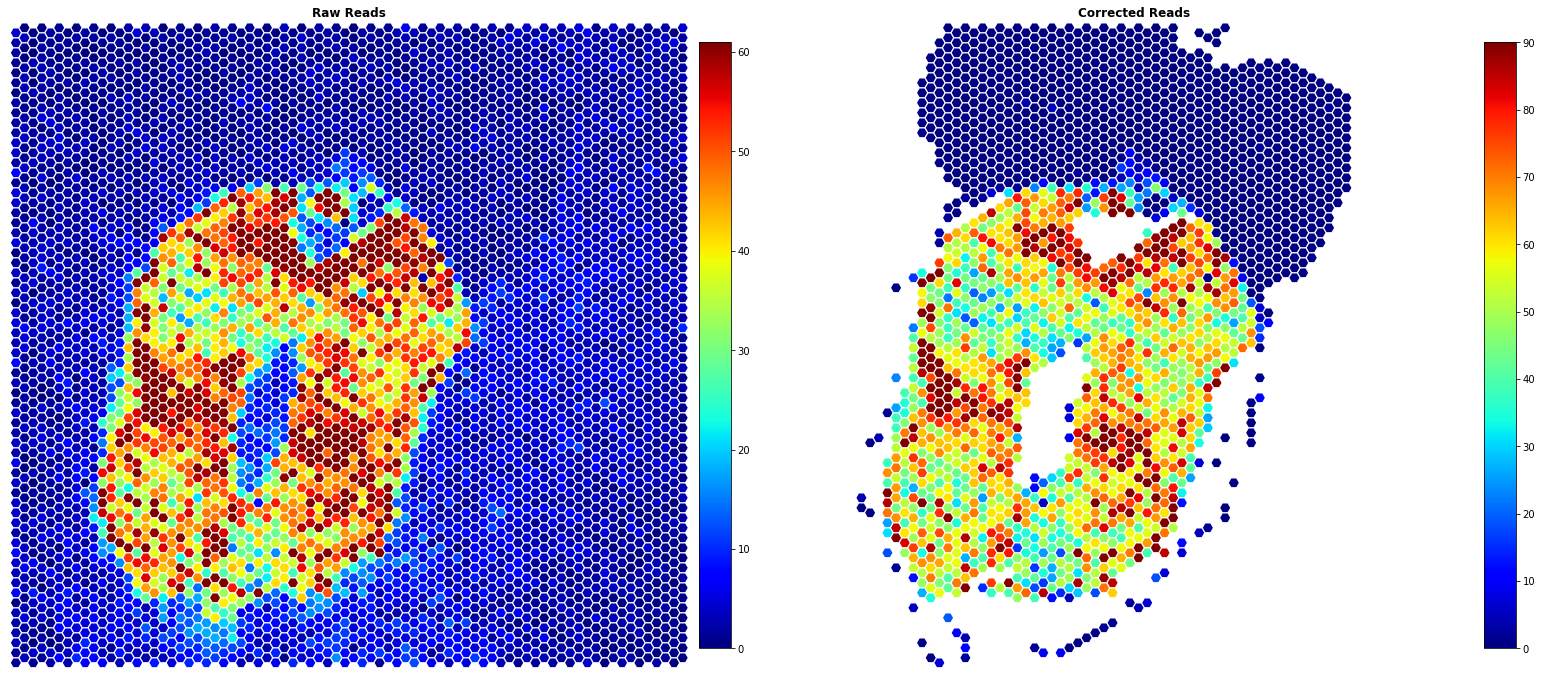

In [14]:
Image(filename='{}_bleeding_plot.png'.format(cleaned_dataset.gene_names[1]), unconfined=True) 
